__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Ср 19 июн 2024 13:05:51 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

27326

title  \
3257     участок, 4 сот., ижс   
7460  участок, 6.28 сот., ижс   
1663     участок, 4 сот., ижс   

                                                                                  address  \
3257  севастополь,р-н нахимовский,алькадар садовое товарищество,улица сержанта стрельцова   
7460                 севастополь,р-н балаклавский,торпедо-1 садоводческое товарищество,35   
1663                    севастополь,р-н гагаринский,мкр.стрелецкая бухта,улица коралловая   

      latitude  longitude  priceM          dt  
3257     44.66      33.56    2.30  2024-06-17  
7460     44.52      33.54    2.70  2024-06-18  
1663     44.59      33.47    4.50  2024-06-07

---

In [4]:
# df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
# df_['dt'] = df_['ts'].dt.date
# display( len(df_) )
# display( df_.sample(3)[cols] )

In [5]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [6]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [7]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

In [8]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

---

In [9]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))

---

In [10]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [11]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

27326

27326

In [12]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [13]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
14273           участок 12 сот. (ижс)   
1250             участок, 4 сот., ижс   
1751   участок, 6.7 сот., садоводство   

                                                               address  \
14273                                       севастополь,коралловая ул.   
1250               севастополь,р-н гагаринский,улица эдуарда асадова,4   
1751   севастополь,р-н гагаринский,южный садоводческое товарищество,21   

       latitude  longitude  priceM          dt  
14273     44.59      33.47   15.00  2024-06-10  
1250      44.57      33.48    4.00  2024-06-11  
1751      44.57      33.50    4.25  2024-06-07

In [14]:
display( len(df) )
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')
display( len(df) )

27326

27326

---

In [15]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,dt_max )
# display( dt_min,history_date,dt_max )

datetime.date(2024, 6, 7)

datetime.date(2024, 6, 19)

In [16]:
# display( len(gdf_history) )
display( len(gdf) )

27297

# общая статистика

In [17]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [18]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [19]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [20]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [21]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [22]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = gdf.groupby(['place','area_size_category','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat = gdf.groupby(['place','area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean   std  min  \
place       area_size_category week                                            
bahchisaray <1                 2024-06-03/2024-06-09   2.00  0.90  0.14 0.80   
                               2024-06-10/2024-06-16   7.00  0.89  0.11 0.80   
                               2024-06-17/2024-06-23   3.00  0.93  0.12 0.80   
            1-2                2024-06-03/2024-06-09   5.00  2.60  2.53 0.50   
                               2024-06-10/2024-06-16  16.00  2.56  2.27 0.50   
...                                                     ...   ...   ...  ...   
sudak       12-20              2024-06-10/2024-06-16  59.00  8.05  8.76 1.00   
                               2024-06-17/2024-06-23  35.00 10.28 13.06 1.00   
            20+                2024-06-03/2024-06-09  31.00 10.67  8.24 0.80   
                               2024-06-10/2024-06-16 125.00 10.57  8.12 0.80   
                               2024-06-17/2024-06-23  84.00 10.68  8.01 1.00   

                                                       1%   5%  10%  25%  50%  \
place       area_size_category week                                             
bahchisaray <1                 2024-06-03/2024-06-09 0.80 0.81 0.82 0.85 0.90   
                               2024-06-10/2024-06-16 0.80 0.80 0.80 0.80 0.80   
                               2024-06-17/2024-06-23 0.80 0.82 0.84 0.90 1.00   
            1-2                2024-06-03/2024-06-09 0.54 0.70 0.90 1.50 2.00   
                               2024-06-10/2024-06-16 0.50 0.50 0.50 1.50 2.00   
...                                                   ...  ...  ...  ...  ...   
sudak       12-20              2024-06-10/2024-06-16 1.00 1.00 1.10 4.30 6.50   
                               2024-06-17/2024-06-23 1.00 1.07 1.10 2.30 6.50   
            20+                2024-06-03/2024-06-09 1.01 2.10 2.85 4.65 7.30   
                               2024-06-10/2024-06-16 0.80 1.50 2.85 4.80 7.30   
                               2024-06-17/2024-06-23 1.83 2.38 2.85 4.80 7.50   

                                                       75%   90%   95%   max  
place       area_size_category week                                           
bahchisaray <1                 2024-06-03/2024-06-09  0.95  0.98  0.99  1.00  
                               2024-06-10/2024-06-16  1.00  1.00  1.00  1.00  
                               2024-06-17/2024-06-23  1.00  1.00  1.00  1.00  
            1-2                2024-06-03/2024-06-09  2.00  5.00  6.00  7.00  
                               2024-06-10/2024-06-16  2.00  7.00  7.00  7.00  
...                                                    ...   ...   ...   ...  
sudak       12-20              2024-06-10/2024-06-16 10.50 11.80 13.00 50.30  
                               2024-06-17/2024-06-23 11.00 13.24 50.30 50.30  
            20+                2024-06-03/2024-06-09 15.40 22.00 28.50 30.00  
                               2024-06-10/2024-06-16 15.50 22.00 30.00 30.00  
                               2024-06-17/2024-06-23 15.35 22.00 30.00 30.00  

[63 rows x 13 columns]

In [23]:
# stat.reset_index()['area_size_category'].unique()

In [24]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = [ '2-4', '4-8', '8-20']
sizes = ['4-8', '8-12', '12-20']
display( sizes )

['4-8', '8-12', '12-20']

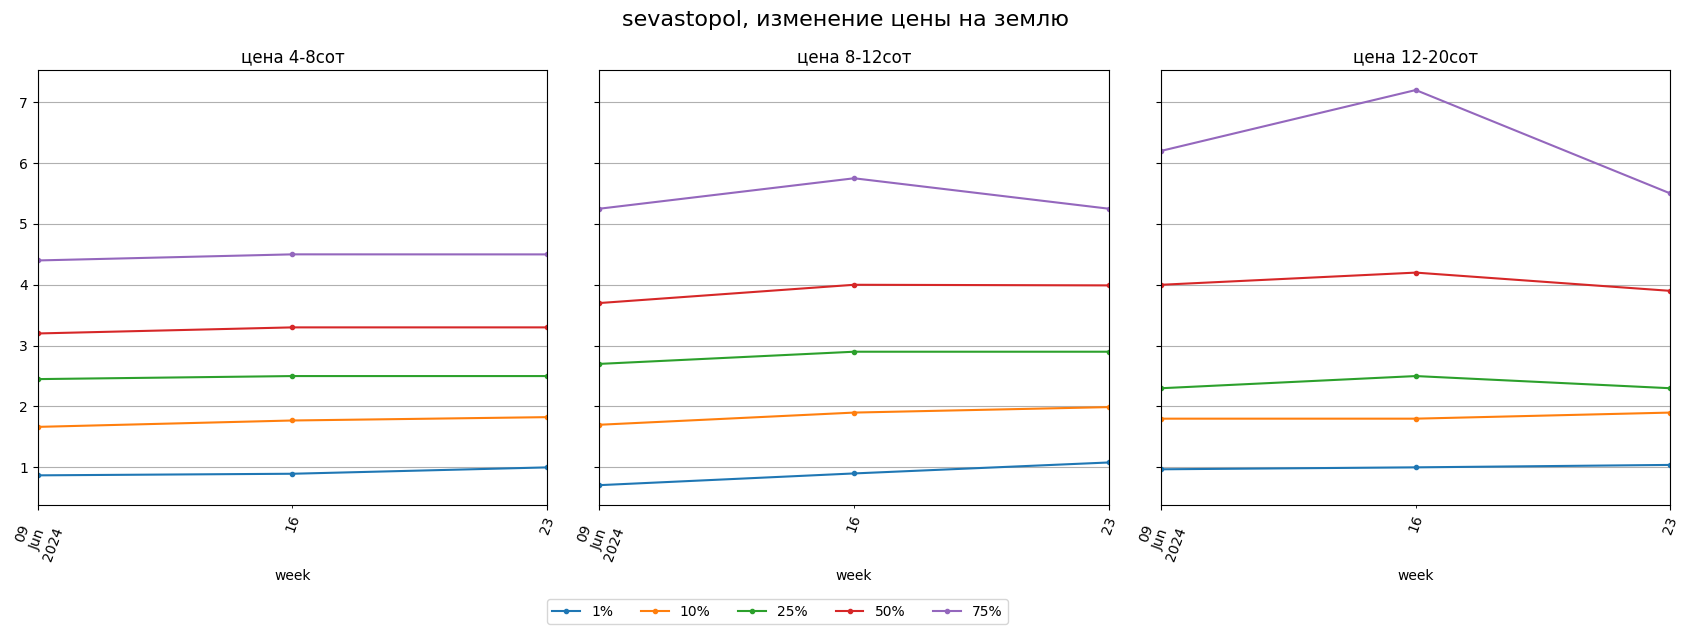

In [25]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

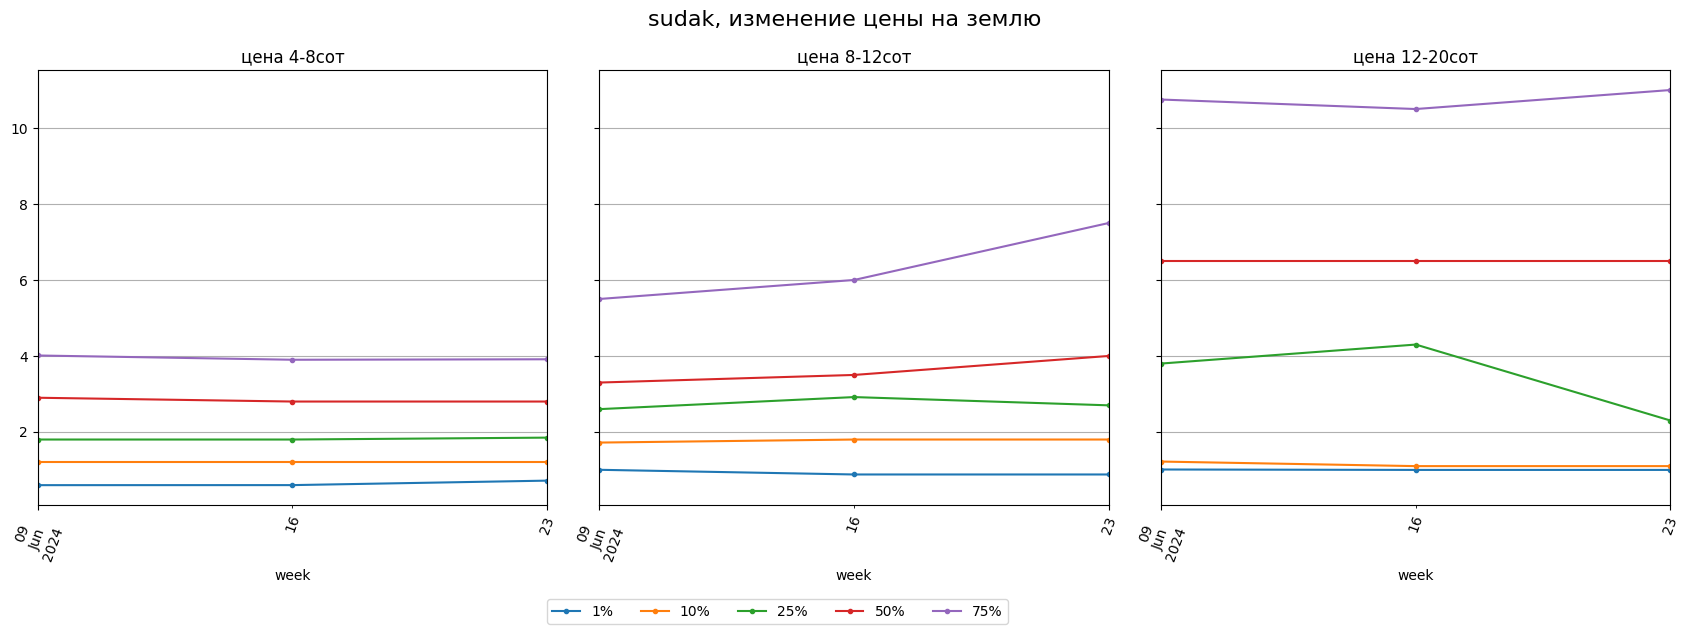

In [26]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

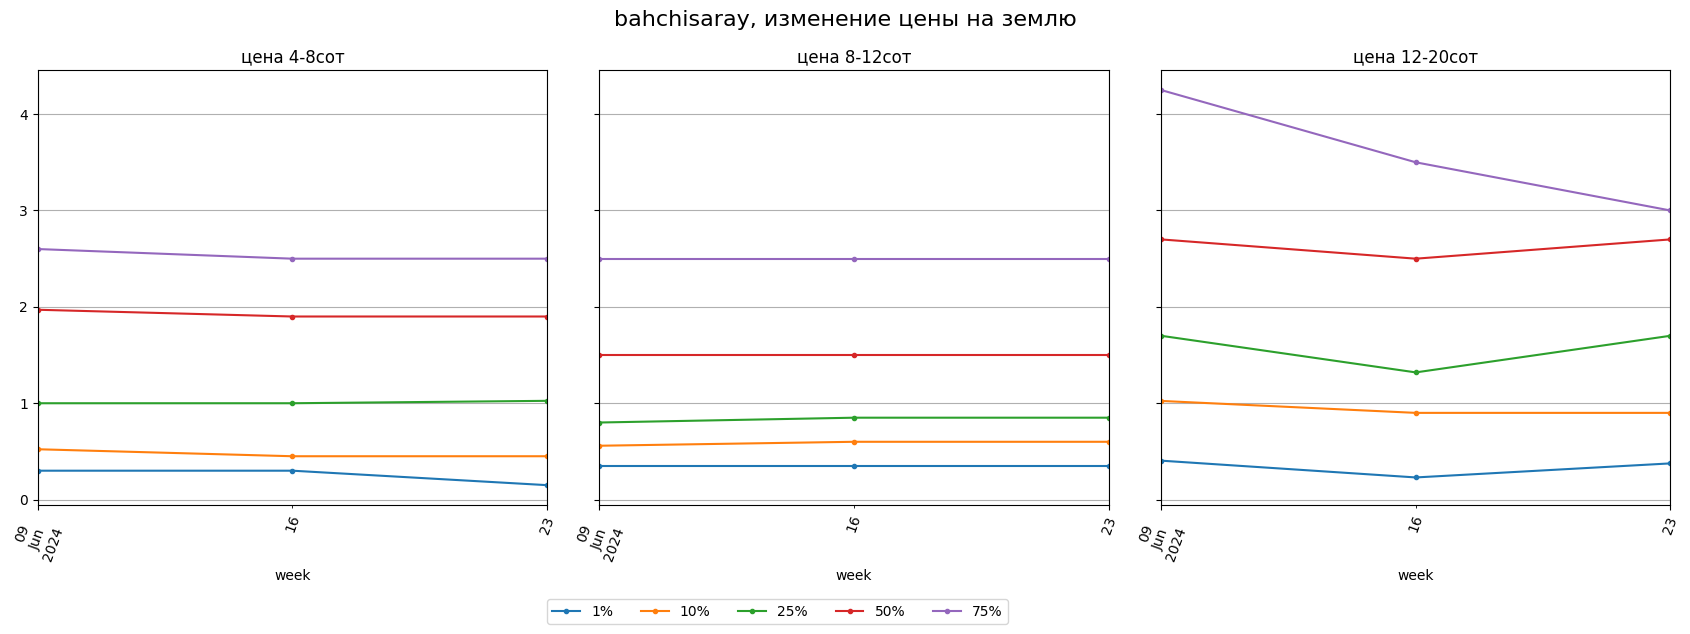

In [27]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [28]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

27297

3848

In [29]:
# display(len(gdf))
# gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
# display(len(gdf_last))

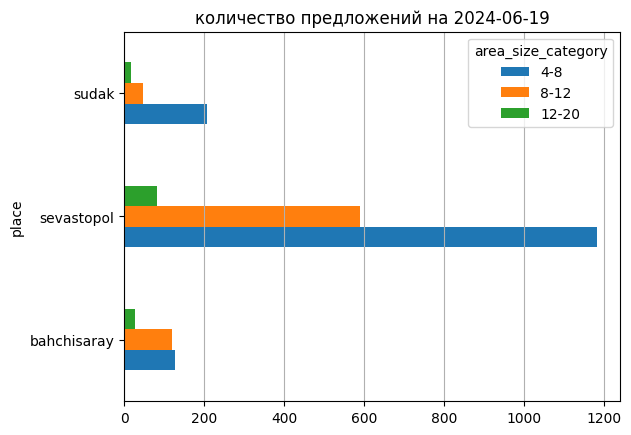

In [30]:
(
gdf_last
.drop_duplicates('url')
.query('area_size_category in @sizes')
.groupby(['area_size_category','place'],observed=True)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( dt_now ))
.grid(axis='x')    
)

In [31]:
(
    gdf_last
    .query('area_size_category in @sizes')
    .drop_duplicates('url')
    .groupby(['place','area_size_category'],observed=True)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean   std  min   1%   5%  10%  25%  \
place       area_size_category                                                
bahchisaray 4-8                 127.00  1.95  1.28 0.00 0.19 0.39 0.47 0.90   
            8-12                119.00  1.92  1.72 0.30 0.35 0.45 0.60 0.82   
            12-20                26.00  3.76  4.01 0.50 0.51 0.64 0.90 1.70   
sevastopol  4-8                1181.00  3.98  3.15 0.36 1.00 1.50 1.90 2.50   
            8-12                590.00  5.10  6.46 0.60 1.10 1.50 1.99 2.90   
            12-20                81.00  5.41  6.79 0.80 0.96 1.50 1.70 2.30   
sudak       4-8                 206.00  3.40  3.00 0.50 0.80 1.10 1.20 1.81   
            8-12                 48.00  5.85  5.31 0.88 0.98 1.22 1.74 2.66   
            12-20                17.00  9.05 11.42 1.00 1.02 1.08 1.10 2.30   

                                50%   75%   90%   95%    max  
place       area_size_category                                
bahchisaray 4-8                1.80  2.50  3.74  4.55   6.90  
            8-12               1.50  2.50  3.50  3.96  16.20  
            12-20              2.70  3.00  9.00 13.50  16.00  
sevastopol  4-8                3.35  4.50  6.50  8.50  70.00  
            8-12               4.00  5.50  8.41 11.27 120.00  
            12-20              3.85  5.50 10.50 15.20  55.00  
sudak       4-8                2.77  3.77  5.95  7.80  30.00  
            8-12               3.75  6.53 11.01 19.65  22.00  
            12-20              6.50 10.50 13.16 20.78  50.30

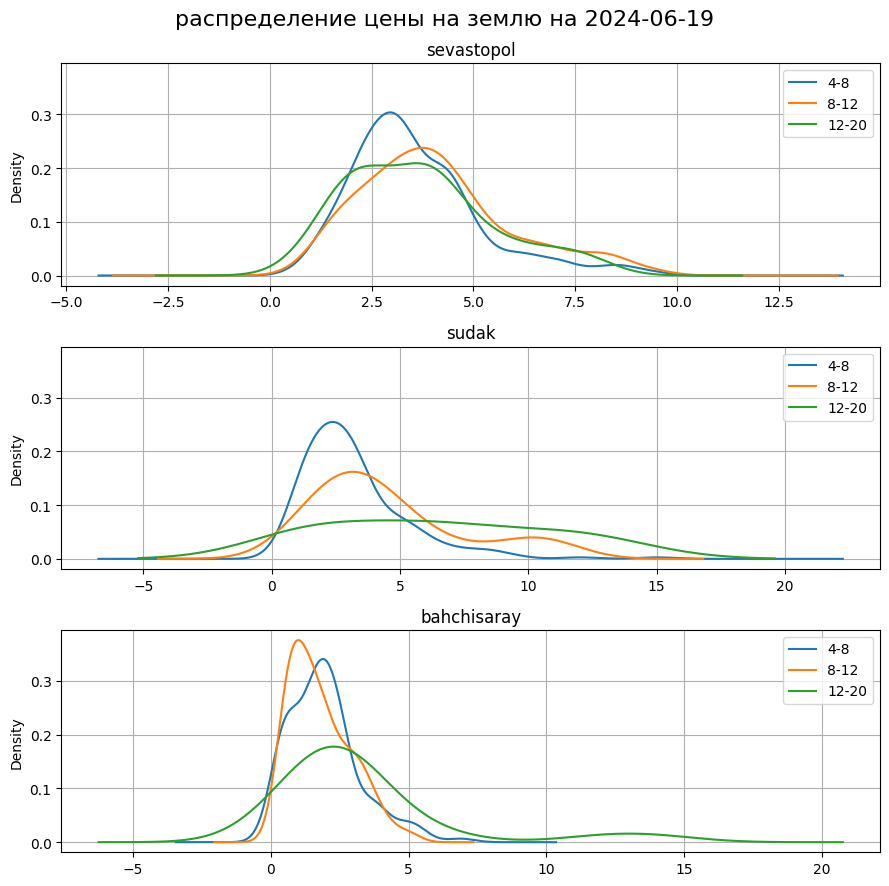

In [32]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})')
        .query('area_size_category in @sizes')
        .drop_duplicates('url')
        .groupby(['area_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на землю на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

# цены на карте

In [33]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [34]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

## Севастополь

In [35]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [36]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [37]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( 
        gdf_last
        .query('place=="sevastopol"')
        .query('area_size_category in @sizes')
        .drop_duplicates('url')
        ,  how='inner',)
    .groupby(['hex_id'])
    [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

## Судак

In [38]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [39]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [40]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( 
        gdf_last
        .query('place=="sudak"')
        .query('area_size_category in @sizes')
        .drop_duplicates('url')
        , how='inner',)
    .groupby(['hex_id'])
   [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

# районы Севастополя

In [41]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [42]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [43]:
frames.explore('area_name', legend=True)

In [44]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [45]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

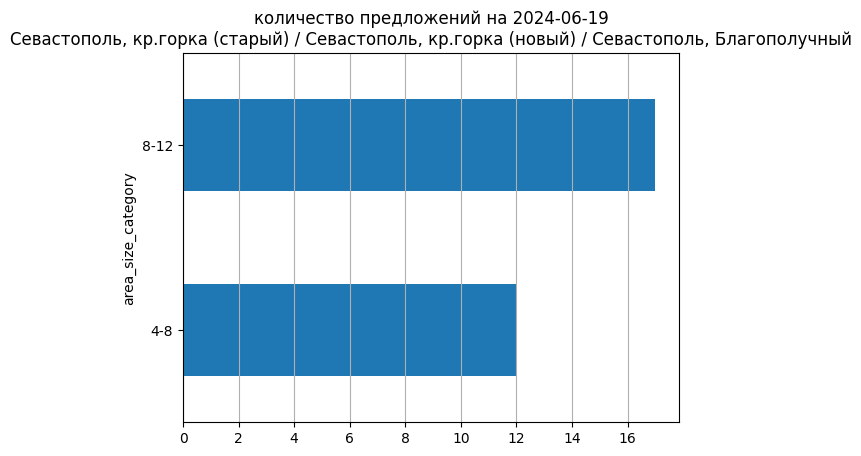

In [46]:
(
    gdf_last_local
    .query('area_size_category in @sizes')
    .drop_duplicates('url')
    .groupby(['area_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( dt_now ) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

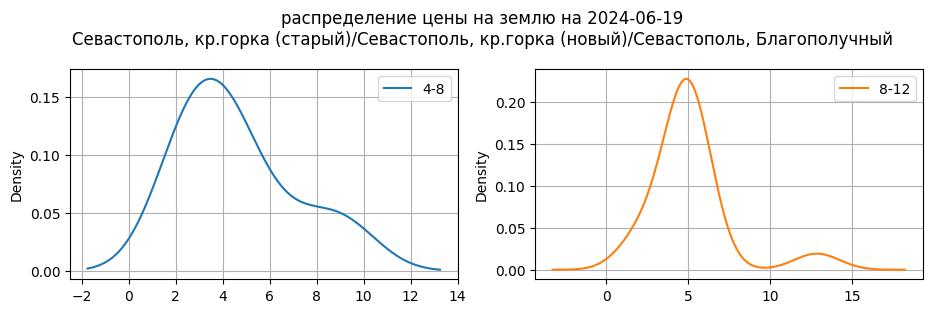

In [47]:
q_95 = gdf_last_local['priceM'].quantile(.95)
sizes_ = ['4-8', '8-12' ]
# fig, ax = plt.subplots() #figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .query('area_size_category in @sizes_')
    #.groupby(['house_size_category'],observed=True)
    .pivot(columns='area_size_category',values='priceM')
    #['priceM']
    #.count()
    .plot.kde(
        legend=True,
        #ax=ax,
        # title='/'.join(area_name), 
        title=f'распределение цены на землю на '+ str( dt_now )+ '\n'+'/'.join(area_name), 
        grid=True,
        subplots=True,
        layout=(2,2),
        figsize=(11,6),
        sharex=False
    )   
)
#fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
#fig.tight_layout()

In [48]:
# q_95 = gdf_last_local['priceM'].quantile(.95)
# sizes_ = ['4-8', '8-12' ]

# fig, ax = plt.subplots(figsize=(7,3) )
# (
#     gdf_last_local
#     .query(f'(priceM<{q_95})')
#     .query('area_size_category in @sizes_')
#     .drop_duplicates('url')
#     .groupby(['area_size_category'],observed=True)
#     ['priceM']
#     # .count()
#     .plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
# )
# fig.suptitle(f'распределение цены на землю на '+ str(dt_now ), fontsize=16)
# fig.tight_layout()

----

In [49]:
# изменение цены по району
gdf_local = (
    gdf
    .query('area_size_category in @sizes_')
    .drop_duplicates('url')
    .sjoin( frame_, how='inner', predicate='within') 
)

In [50]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = gdf_local.groupby(['area_size_category','week'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat = gdf_local.groupby(['area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean  std  min   1%   5%  \
area_size_category week                                                     
4-8                2024-06-03/2024-06-09   1.00  3.90  NaN 3.90 3.90 3.90   
                   2024-06-10/2024-06-16  14.00  4.55 2.12 2.45 2.45 2.45   
                   2024-06-17/2024-06-23   8.00  5.94 3.49 2.00 2.04 2.17   
8-12               2024-06-03/2024-06-09   2.00  4.20 0.99 3.50 3.51 3.57   
                   2024-06-10/2024-06-16  12.00  6.14 4.67 2.10 2.25 2.87   
                   2024-06-17/2024-06-23  10.00  6.51 3.78 2.10 2.35 3.36   

                                          10%  25%  50%  75%   90%   95%   max  
area_size_category week                                                         
4-8                2024-06-03/2024-06-09 3.90 3.90 3.90 3.90  3.90  3.90  3.90  
                   2024-06-10/2024-06-16 2.48 3.25 3.95 4.98  7.55  8.52  9.50  
                   2024-06-17/2024-06-23 2.35 4.00 4.90 7.53 10.60 11.30 12.00  
8-12               2024-06-03/2024-06-09 3.64 3.85 4.20 4.55  4.76  4.83  4.90  
                   2024-06-10/2024-06-16 3.52 4.11 4.50 4.96 14.90 16.00 16.00  
                   2024-06-17/2024-06-23 4.62 5.00 5.15 5.50 12.96 13.48 13.99

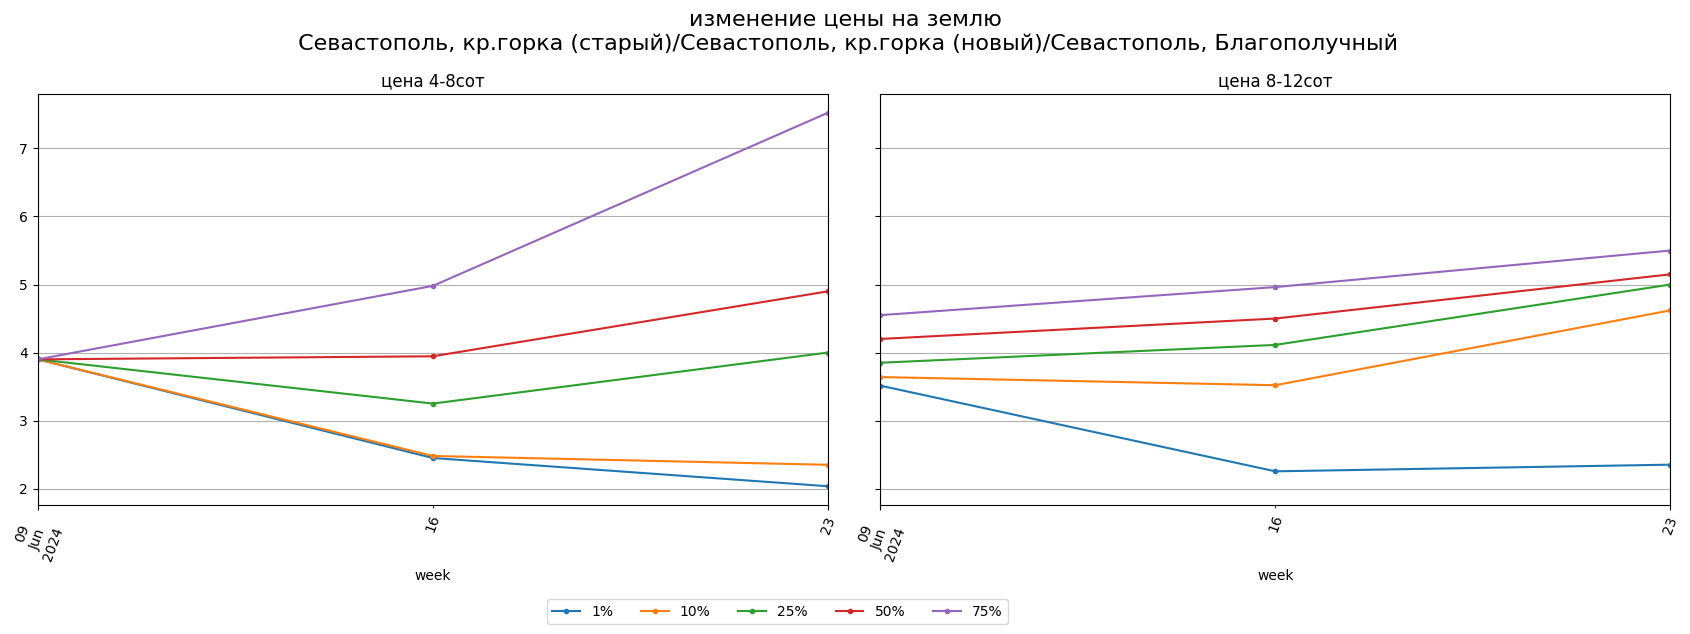

In [51]:
fig, ax = plt.subplots(1,len(sizes_),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes_): 
    stat.loc[(s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

-----

In [ ]:
# #           46.319437, 33.911048
# #
# # 45.402617, 32.455625 |  45.545301, 36.684702
# #
# #          44.320887, 33.917013

# display( len(df) )
# df = df.query('(32.4<longitude<36.7) & (44.3<latitude<46.4)') 
# display( len(df) )

# # df.loc[ df['address'].str.lower().str.match(r'бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
# # df.loc[ df['address'].str.lower().str.match(r'бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 

In [ ]:
# # df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None
# df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
# df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

# df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
# df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

# df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

# df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'

# df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

# df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
# df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
# df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
# df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'